In [1]:
import numpy as np

# Функція активації (sigmoid) та її похідна
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

# Визначимо клас для нейронної мережі
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Випадкове ініціалізування ваг
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.weights_input_hidden = np.random.uniform(size=(input_size, hidden_size))
        self.weights_hidden_output = np.random.uniform(size=(hidden_size, output_size))

    # Пряме проходження через мережу
    def forward(self, inputs):
        self.hidden = sigmoid(np.dot(inputs, self.weights_input_hidden))
        self.output = sigmoid(np.dot(self.hidden, self.weights_hidden_output))
        return self.output

    # Зворотне поширення помилки
    def backpropagate(self, inputs, outputs, expected_output, learning_rate):
        output_error = expected_output - outputs
        output_delta = output_error * sigmoid_derivative(outputs)
        
        hidden_error = np.dot(output_delta, self.weights_hidden_output.T)
        hidden_delta = hidden_error * sigmoid_derivative(self.hidden)
        
        # Оновлення ваг
        self.weights_hidden_output += np.dot(self.hidden.T, output_delta) * learning_rate
        self.weights_input_hidden += np.dot(inputs.T, hidden_delta) * learning_rate

    # Оцінка помилки
    def compute_loss(self, expected_output, output):
        return np.mean(np.square(expected_output - output))


In [2]:
import random

# Створимо клас для генетичного алгоритму
class GeneticAlgorithm:
    def __init__(self, population_size, mutation_rate, crossover_rate, nn_architecture):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.nn_architecture = nn_architecture
        self.population = [NeuralNetwork(*nn_architecture) for _ in range(population_size)]

    # Функція для відбору найбільш придатних індивідів
    def selection(self, X, y):
        fitness_scores = [(nn, nn.compute_loss(y, nn.forward(X))) for nn in self.population]
        fitness_scores.sort(key=lambda x: x[1])  # Сортуємо за помилкою (чим менша, тим краща)
        return [nn for nn, score in fitness_scores[:self.population_size // 2]]  # Повертаємо половину

    # Функція схрещування двох батьків для створення дитини
    def crossover(self, parent1, parent2):
        child = NeuralNetwork(*self.nn_architecture)
        for i in range(self.nn_architecture[1]):
            if random.random() < self.crossover_rate:
                child.weights_input_hidden[:, i] = parent1.weights_input_hidden[:, i]
            else:
                child.weights_input_hidden[:, i] = parent2.weights_input_hidden[:, i]
        
        for i in range(self.nn_architecture[2]):
            if random.random() < self.crossover_rate:
                child.weights_hidden_output[:, i] = parent1.weights_hidden_output[:, i]
            else:
                child.weights_hidden_output[:, i] = parent2.weights_hidden_output[:, i]
        
        return child

    # Функція мутації
    def mutate(self, individual):
        for i in range(self.nn_architecture[1]):
            if random.random() < self.mutation_rate:
                individual.weights_input_hidden[:, i] += np.random.normal(0, 0.1, size=(self.nn_architecture[0],))
        
        for i in range(self.nn_architecture[2]):
            if random.random() < self.mutation_rate:
                individual.weights_hidden_output[:, i] += np.random.normal(0, 0.1, size=(self.nn_architecture[1],))
        
    # Основний процес еволюції
    def evolve(self, X, y, generations):
        for generation in range(generations):
            selected = self.selection(X, y)
            children = []

            # Схрещування
            for i in range(len(selected) // 2):
                parent1 = selected[i]
                parent2 = selected[-i - 1]
                child = self.crossover(parent1, parent2)
                children.append(child)

            # Мутація
            for child in children:
                self.mutate(child)

            # Оновлення популяції
            self.population = selected + children
            print(f'Generation {generation}, Best Loss: {self.selection(X, y)[0].compute_loss(y, self.selection(X, y)[0].forward(X))}')


In [4]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

df = sm.datasets.macrodata.load_pandas().data

def create_date(row):
    return pd.Timestamp(year=int(row['year']), month=int(row['quarter'] * 3 - 2), day=1)

df['date'] = df.apply(create_date, axis=1)

year = df.drop_duplicates("year")

X = year[['realgdp', 'realcons', 'realinv', 'realgovt',
        'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']].values  # Вхідні змінні
y = year['cpi'].values 

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [6]:
# Параметри
input_size = 12
hidden_size = 4
output_size = 1
population_size = 10
mutation_rate = 0.01
crossover_rate = 0.7
generations = 100

# Данні для тренування
# X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
# y = np.array([[0], [1], [1], [0]])

# Ініціалізуємо генетичний алгоритм
ga = GeneticAlgorithm(population_size, mutation_rate, crossover_rate, (input_size, hidden_size, output_size))

# Навчання
ga.evolve(X, y, generations)

# Тестування найкращої моделі
best_nn = ga.selection(X, y)[0]
print("Final prediction:", best_nn.forward(X))


Generation 0, Best Loss: 14421.886076604133
Generation 1, Best Loss: 14421.331675788913
Generation 2, Best Loss: 14421.331675788913
Generation 3, Best Loss: 14421.331675788913
Generation 4, Best Loss: 14421.331675788913
Generation 5, Best Loss: 14421.31768487021
Generation 6, Best Loss: 14421.241192449237
Generation 7, Best Loss: 14420.71593475127
Generation 8, Best Loss: 14420.71593475127
Generation 9, Best Loss: 14420.71593475127
Generation 10, Best Loss: 14420.63060881453
Generation 11, Best Loss: 14420.63060881453
Generation 12, Best Loss: 14420.63060881453
Generation 13, Best Loss: 14420.626858748636
Generation 14, Best Loss: 14420.626858748636
Generation 15, Best Loss: 14420.626858748636
Generation 16, Best Loss: 14420.626858748636
Generation 17, Best Loss: 14420.626858748636
Generation 18, Best Loss: 14420.626858748636
Generation 19, Best Loss: 14420.626858748636
Generation 20, Best Loss: 14420.626858748636
Generation 21, Best Loss: 14420.626858748636
Generation 22, Best Loss: 1

Training on window 1 (0-20)
Generation 0, Best Loss: 1642.6129044200643
Generation 1, Best Loss: 1642.4358448395828
Generation 2, Best Loss: 1642.0721573774172
Generation 3, Best Loss: 1642.0721573774172
Generation 4, Best Loss: 1642.0721573774172
Generation 5, Best Loss: 1642.0721573774172
Generation 6, Best Loss: 1642.036331573523
Generation 7, Best Loss: 1642.036331573523
Generation 8, Best Loss: 1642.036331573523
Generation 9, Best Loss: 1642.036331573523
Generation 10, Best Loss: 1642.036331573523
Generation 11, Best Loss: 1642.036331573523
Generation 12, Best Loss: 1642.036331573523
Generation 13, Best Loss: 1642.036331573523
Generation 14, Best Loss: 1641.9245480844681
Generation 15, Best Loss: 1641.9245480844681
Generation 16, Best Loss: 1641.9245480844681
Generation 17, Best Loss: 1641.8374148523028
Generation 18, Best Loss: 1641.8374148523028
Generation 19, Best Loss: 1641.8374148523028
Generation 20, Best Loss: 1641.8374148523028
Generation 21, Best Loss: 1641.8374148523028


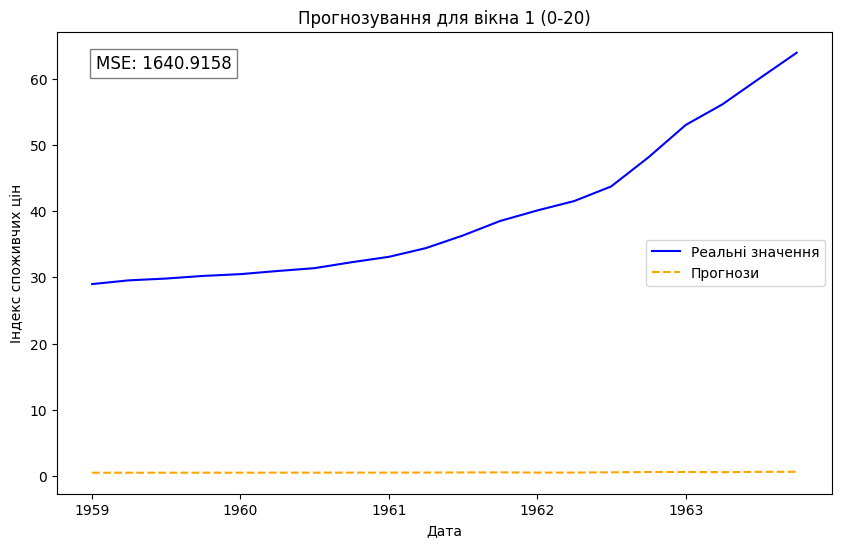

Training on window 2 (1-21)
Generation 0, Best Loss: 1843.87523041669
Generation 1, Best Loss: 1843.87523041669
Generation 2, Best Loss: 1843.87523041669
Generation 3, Best Loss: 1843.87523041669
Generation 4, Best Loss: 1843.6307393795928
Generation 5, Best Loss: 1843.6307393795928
Generation 6, Best Loss: 1843.6307393795928
Generation 7, Best Loss: 1843.6307393795928
Generation 8, Best Loss: 1843.6307393795928
Generation 9, Best Loss: 1843.6307393795928
Generation 10, Best Loss: 1843.6307393795928
Generation 11, Best Loss: 1843.6307393795928
Generation 12, Best Loss: 1843.6307393795928
Generation 13, Best Loss: 1843.6307393795928
Generation 14, Best Loss: 1843.6307393795928
Generation 15, Best Loss: 1843.6307393795928
Generation 16, Best Loss: 1843.6307393795928
Generation 17, Best Loss: 1843.6307393795928
Generation 18, Best Loss: 1843.6307393795928
Generation 19, Best Loss: 1842.929325049618
Generation 20, Best Loss: 1842.929325049618
Generation 21, Best Loss: 1842.929325049618
Gen

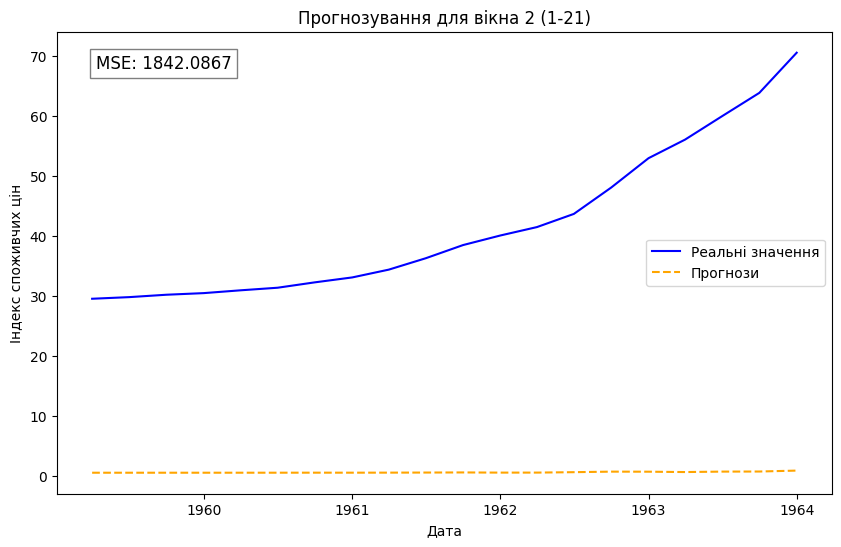

Training on window 3 (2-22)
Generation 0, Best Loss: 2121.6565393094475
Generation 1, Best Loss: 2121.6565393094475
Generation 2, Best Loss: 2121.041925008195
Generation 3, Best Loss: 2120.086324307047
Generation 4, Best Loss: 2120.086324307047
Generation 5, Best Loss: 2120.086324307047
Generation 6, Best Loss: 2120.0684107238803
Generation 7, Best Loss: 2120.0684107238803
Generation 8, Best Loss: 2120.0684107238803
Generation 9, Best Loss: 2120.0684107238803
Generation 10, Best Loss: 2120.0684107238803
Generation 11, Best Loss: 2120.0684107238803
Generation 12, Best Loss: 2120.0684107238803
Generation 13, Best Loss: 2120.0684107238803
Generation 14, Best Loss: 2120.0684107238803
Generation 15, Best Loss: 2120.0684107238803
Generation 16, Best Loss: 2120.0684107238803
Generation 17, Best Loss: 2120.0684107238803
Generation 18, Best Loss: 2120.0684107238803
Generation 19, Best Loss: 2120.0684107238803
Generation 20, Best Loss: 2120.0684107238803
Generation 21, Best Loss: 2120.0684107238

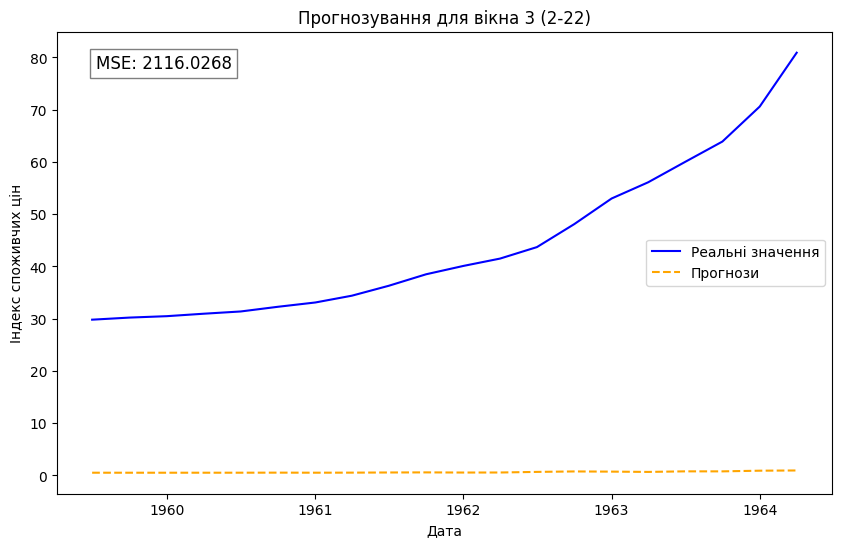

Training on window 4 (3-23)
Generation 0, Best Loss: 2468.895963114964
Generation 1, Best Loss: 2468.816037986612
Generation 2, Best Loss: 2468.816037986612
Generation 3, Best Loss: 2468.816037986612
Generation 4, Best Loss: 2468.816037986612
Generation 5, Best Loss: 2468.816037986612
Generation 6, Best Loss: 2468.3640132227324
Generation 7, Best Loss: 2468.3640132227324
Generation 8, Best Loss: 2468.3640132227324
Generation 9, Best Loss: 2468.3640132227324
Generation 10, Best Loss: 2468.3640132227324
Generation 11, Best Loss: 2468.3640132227324
Generation 12, Best Loss: 2468.3640132227324
Generation 13, Best Loss: 2468.3640132227324
Generation 14, Best Loss: 2468.3640132227324
Generation 15, Best Loss: 2468.3640132227324
Generation 16, Best Loss: 2468.3640132227324
Generation 17, Best Loss: 2468.2382120016973
Generation 18, Best Loss: 2468.2382120016973
Generation 19, Best Loss: 2468.2382120016973
Generation 20, Best Loss: 2468.2382120016973
Generation 21, Best Loss: 2468.238212001697

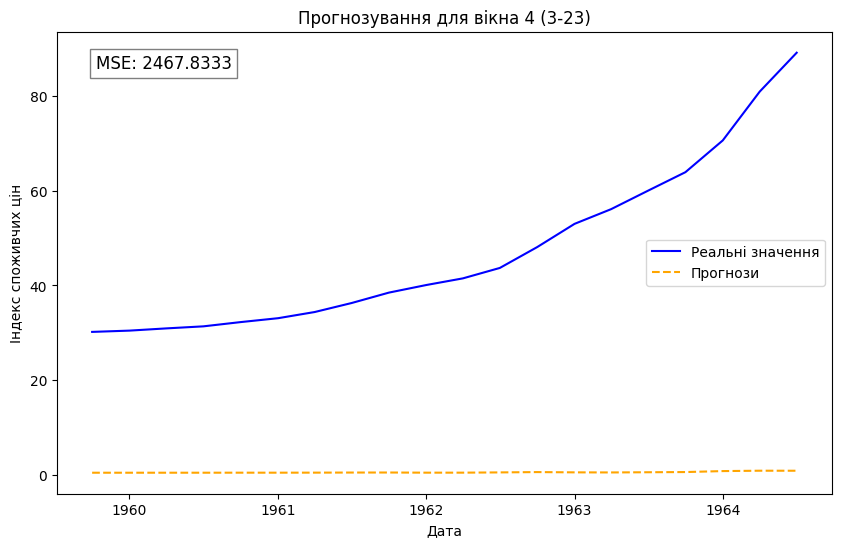

Training on window 5 (4-24)
Generation 0, Best Loss: 2867.2361915286374
Generation 1, Best Loss: 2866.384857626036
Generation 2, Best Loss: 2866.384857626036
Generation 3, Best Loss: 2866.127183446776
Generation 4, Best Loss: 2866.127183446776
Generation 5, Best Loss: 2866.127183446776
Generation 6, Best Loss: 2866.127183446776
Generation 7, Best Loss: 2866.127183446776
Generation 8, Best Loss: 2866.127183446776
Generation 9, Best Loss: 2866.101036782234
Generation 10, Best Loss: 2866.101036782234
Generation 11, Best Loss: 2866.101036782234
Generation 12, Best Loss: 2866.101036782234
Generation 13, Best Loss: 2866.101036782234
Generation 14, Best Loss: 2866.101036782234
Generation 15, Best Loss: 2866.101036782234
Generation 16, Best Loss: 2866.101036782234
Generation 17, Best Loss: 2866.101036782234
Generation 18, Best Loss: 2866.101036782234
Generation 19, Best Loss: 2866.101036782234
Generation 20, Best Loss: 2866.101036782234
Generation 21, Best Loss: 2866.101036782234
Generation 22

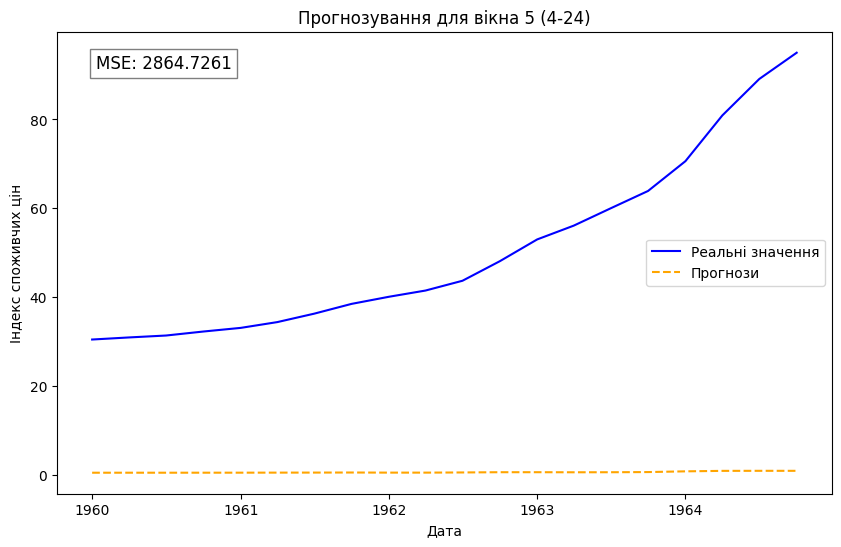

Training on window 6 (5-25)
Generation 0, Best Loss: 3300.985281150436
Generation 1, Best Loss: 3300.985281150436
Generation 2, Best Loss: 3300.4330918305704
Generation 3, Best Loss: 3300.176070667535
Generation 4, Best Loss: 3300.176070667535
Generation 5, Best Loss: 3300.176070667535
Generation 6, Best Loss: 3300.176070667535
Generation 7, Best Loss: 3300.176070667535
Generation 8, Best Loss: 3300.0587812207123
Generation 9, Best Loss: 3300.0587812207123
Generation 10, Best Loss: 3300.0191230454884
Generation 11, Best Loss: 3300.0191230454884
Generation 12, Best Loss: 3300.0191230454884
Generation 13, Best Loss: 3300.0191230454884
Generation 14, Best Loss: 3300.0191230454884
Generation 15, Best Loss: 3300.0191230454884
Generation 16, Best Loss: 3300.0191230454884
Generation 17, Best Loss: 3300.0191230454884
Generation 18, Best Loss: 3300.0191230454884
Generation 19, Best Loss: 3300.0191230454884
Generation 20, Best Loss: 3300.0191230454884
Generation 21, Best Loss: 3300.0191230454884

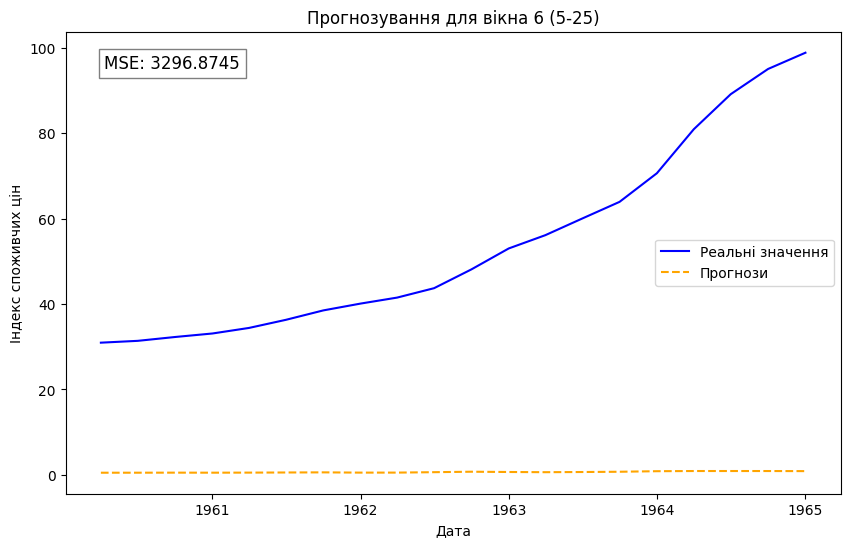

Training on window 7 (6-26)
Generation 0, Best Loss: 3779.997559420825
Generation 1, Best Loss: 3779.997559420825
Generation 2, Best Loss: 3779.997559420825
Generation 3, Best Loss: 3779.997559420825
Generation 4, Best Loss: 3777.902526369464
Generation 5, Best Loss: 3777.902526369464
Generation 6, Best Loss: 3777.902526369464
Generation 7, Best Loss: 3777.449764910483
Generation 8, Best Loss: 3777.449764910483
Generation 9, Best Loss: 3777.449764910483
Generation 10, Best Loss: 3777.449764910483
Generation 11, Best Loss: 3777.2955489652304
Generation 12, Best Loss: 3777.2955489652304
Generation 13, Best Loss: 3777.2955489652304
Generation 14, Best Loss: 3777.013463633068
Generation 15, Best Loss: 3777.013463633068
Generation 16, Best Loss: 3776.9176064352796
Generation 17, Best Loss: 3776.9176064352796
Generation 18, Best Loss: 3776.9176064352796
Generation 19, Best Loss: 3776.9176064352796
Generation 20, Best Loss: 3776.9176064352796
Generation 21, Best Loss: 3776.9176064352796
Gener

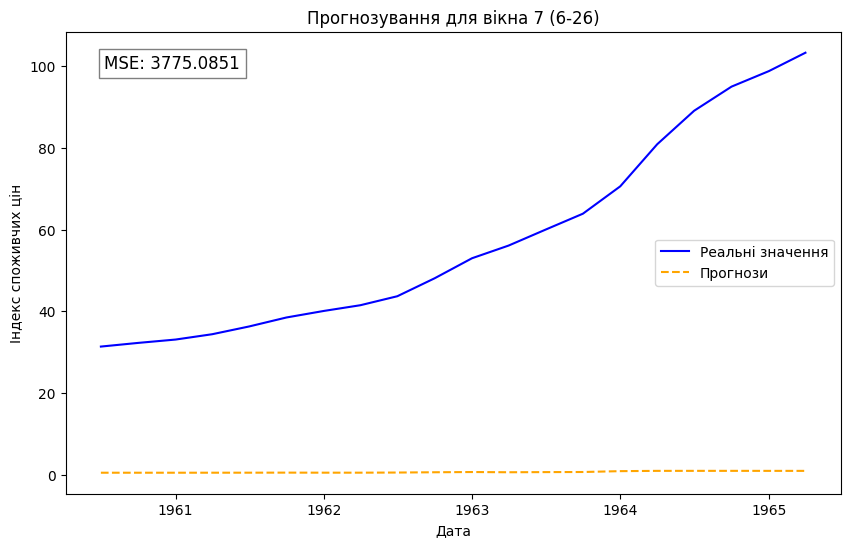

Training on window 8 (7-27)
Generation 0, Best Loss: 4294.99393566324
Generation 1, Best Loss: 4294.99393566324
Generation 2, Best Loss: 4294.99393566324
Generation 3, Best Loss: 4294.99393566324
Generation 4, Best Loss: 4294.99393566324
Generation 5, Best Loss: 4294.99393566324
Generation 6, Best Loss: 4294.99393566324
Generation 7, Best Loss: 4294.99393566324
Generation 8, Best Loss: 4294.99393566324
Generation 9, Best Loss: 4294.99393566324
Generation 10, Best Loss: 4294.99393566324
Generation 11, Best Loss: 4294.99393566324
Generation 12, Best Loss: 4294.99393566324
Generation 13, Best Loss: 4294.99393566324
Generation 14, Best Loss: 4294.99393566324
Generation 15, Best Loss: 4294.99393566324
Generation 16, Best Loss: 4294.99393566324
Generation 17, Best Loss: 4294.99393566324
Generation 18, Best Loss: 4294.99393566324
Generation 19, Best Loss: 4294.99393566324
Generation 20, Best Loss: 4294.99393566324
Generation 21, Best Loss: 4294.99393566324
Generation 22, Best Loss: 4294.70332

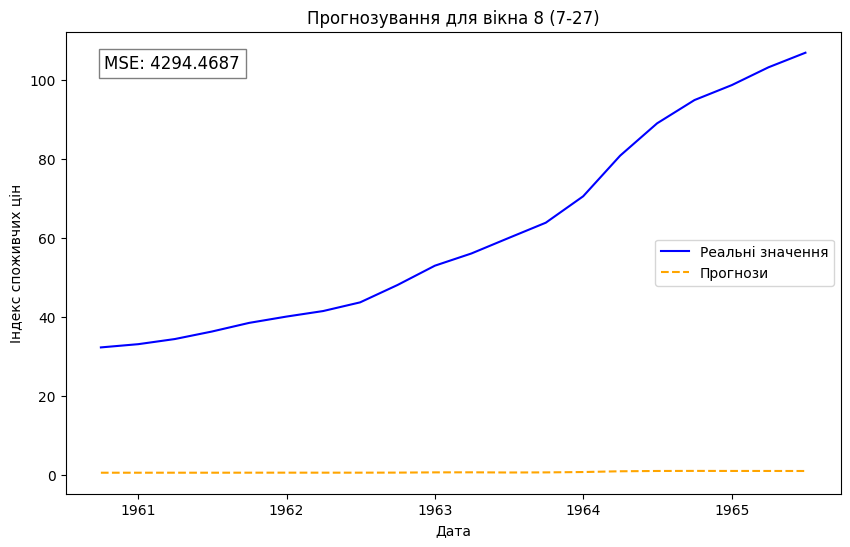

Training on window 9 (8-28)
Generation 0, Best Loss: 4824.606675594798
Generation 1, Best Loss: 4824.210409878646
Generation 2, Best Loss: 4824.210409878646
Generation 3, Best Loss: 4821.684487011378
Generation 4, Best Loss: 4819.805993093671
Generation 5, Best Loss: 4819.805993093671
Generation 6, Best Loss: 4819.805993093671
Generation 7, Best Loss: 4819.805993093671
Generation 8, Best Loss: 4819.805993093671
Generation 9, Best Loss: 4819.805993093671
Generation 10, Best Loss: 4819.805993093671
Generation 11, Best Loss: 4819.188247535712
Generation 12, Best Loss: 4819.188247535712
Generation 13, Best Loss: 4819.188247535712
Generation 14, Best Loss: 4819.188247535712
Generation 15, Best Loss: 4819.188247535712
Generation 16, Best Loss: 4819.188247535712
Generation 17, Best Loss: 4819.188247535712
Generation 18, Best Loss: 4819.188247535712
Generation 19, Best Loss: 4819.188247535712
Generation 20, Best Loss: 4819.188247535712
Generation 21, Best Loss: 4819.188247535712
Generation 22,

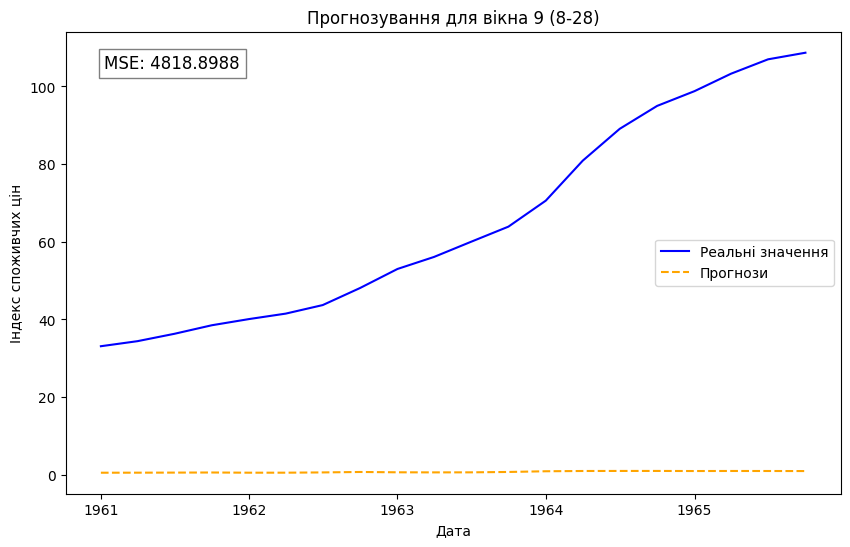

Training on window 10 (9-29)
Generation 0, Best Loss: 5399.209559728015
Generation 1, Best Loss: 5399.209559728015
Generation 2, Best Loss: 5398.687222167894
Generation 3, Best Loss: 5398.665787495549
Generation 4, Best Loss: 5398.665787495549
Generation 5, Best Loss: 5398.665787495549
Generation 6, Best Loss: 5398.665787495549
Generation 7, Best Loss: 5398.663988504095
Generation 8, Best Loss: 5398.663988504095
Generation 9, Best Loss: 5398.663988504095
Generation 10, Best Loss: 5398.663988504095
Generation 11, Best Loss: 5398.663988504095
Generation 12, Best Loss: 5398.663988504095
Generation 13, Best Loss: 5398.663988504095
Generation 14, Best Loss: 5398.663988504095
Generation 15, Best Loss: 5398.663988504095
Generation 16, Best Loss: 5398.663988504095
Generation 17, Best Loss: 5398.663988504095
Generation 18, Best Loss: 5398.663988504095
Generation 19, Best Loss: 5398.663988504095
Generation 20, Best Loss: 5398.663988504095
Generation 21, Best Loss: 5398.663988504095
Generation 22

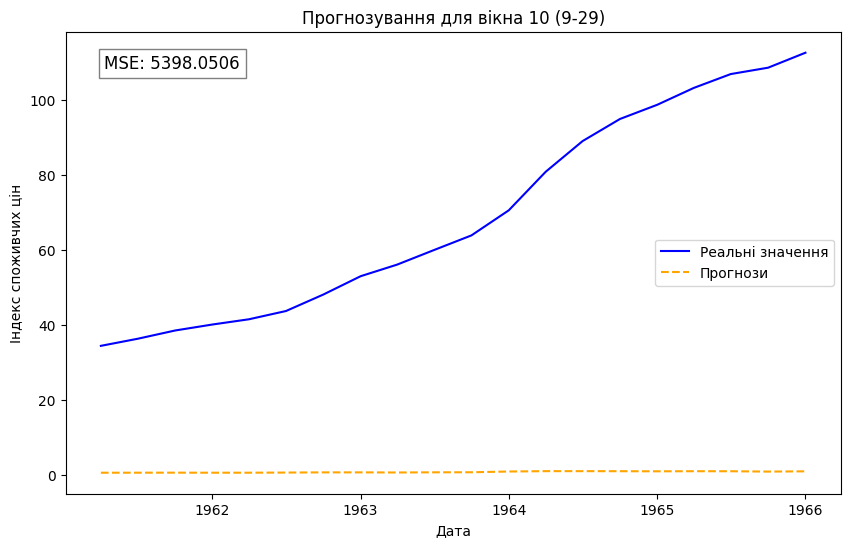

Training on window 11 (10-30)
Generation 0, Best Loss: 6012.1168710574475
Generation 1, Best Loss: 6011.828732590238
Generation 2, Best Loss: 6010.634880874835
Generation 3, Best Loss: 6010.634880874835
Generation 4, Best Loss: 6010.634880874835
Generation 5, Best Loss: 6010.634880874835
Generation 6, Best Loss: 6010.634880874835
Generation 7, Best Loss: 6010.634880874835
Generation 8, Best Loss: 6010.634880874835
Generation 9, Best Loss: 6010.634880874835
Generation 10, Best Loss: 6010.634880874835
Generation 11, Best Loss: 6010.634880874835
Generation 12, Best Loss: 6010.634880874835
Generation 13, Best Loss: 6010.634880874835
Generation 14, Best Loss: 6010.634880874835
Generation 15, Best Loss: 6010.634880874835
Generation 16, Best Loss: 6010.634880874835
Generation 17, Best Loss: 6010.634880874835
Generation 18, Best Loss: 6010.634880874835
Generation 19, Best Loss: 6010.634880874835
Generation 20, Best Loss: 6010.634880874835
Generation 21, Best Loss: 6010.634880874835
Generation 

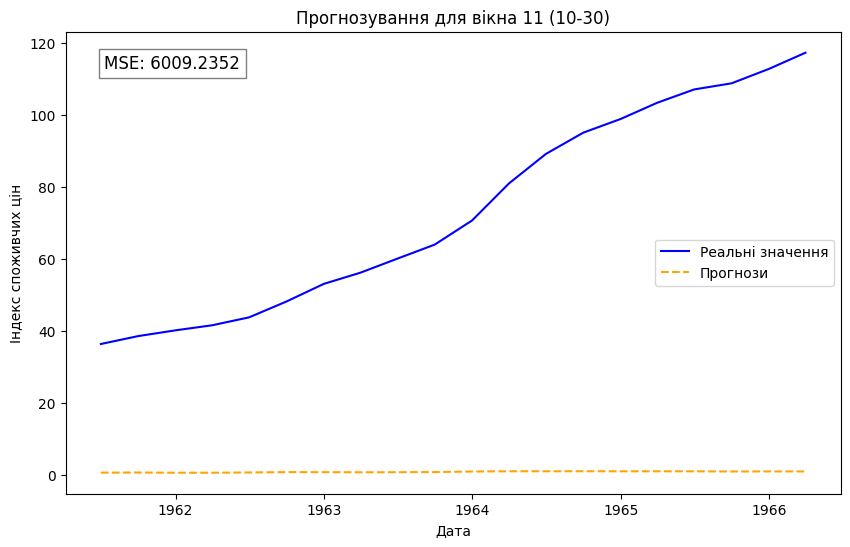

Training on window 12 (11-31)
Generation 0, Best Loss: 6700.18066510784
Generation 1, Best Loss: 6698.920215750569
Generation 2, Best Loss: 6698.920215750569
Generation 3, Best Loss: 6698.920215750569
Generation 4, Best Loss: 6698.336786997218
Generation 5, Best Loss: 6698.336786997218
Generation 6, Best Loss: 6698.336786997218
Generation 7, Best Loss: 6698.336786997218
Generation 8, Best Loss: 6698.336786997218
Generation 9, Best Loss: 6698.321441952265
Generation 10, Best Loss: 6698.321441952265
Generation 11, Best Loss: 6698.321441952265
Generation 12, Best Loss: 6698.321441952265
Generation 13, Best Loss: 6698.321441952265
Generation 14, Best Loss: 6698.321441952265
Generation 15, Best Loss: 6698.321441952265
Generation 16, Best Loss: 6698.321441952265
Generation 17, Best Loss: 6698.321441952265
Generation 18, Best Loss: 6698.321441952265
Generation 19, Best Loss: 6698.321441952265
Generation 20, Best Loss: 6698.321441952265
Generation 21, Best Loss: 6698.321441952265
Generation 22

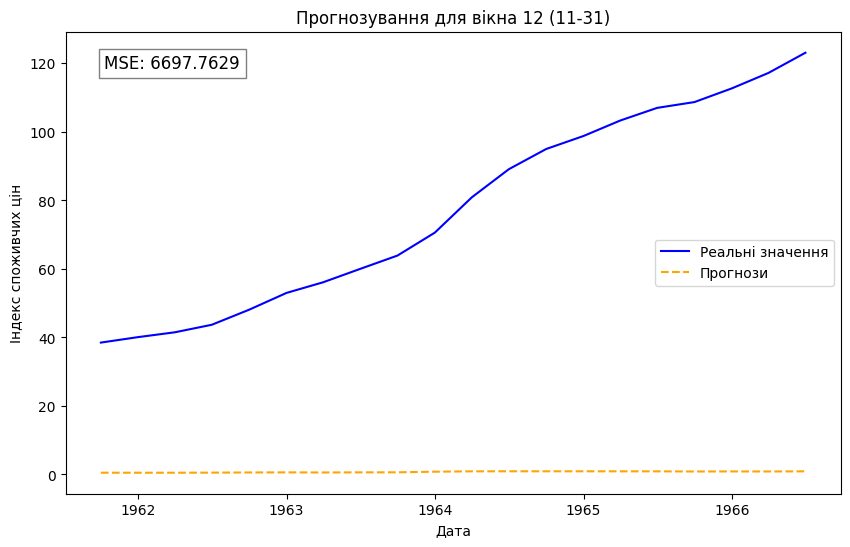

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

n_samples = X.shape[0]  # Кількість зразків у X

# Функція для навчання моделі з використанням ковзного вікна
def sliding_window_training(X, y, window_size=12, num_windows=10, generations=100): 
    for window in range(num_windows):  # Цикл для всіх вікон
        start_index = window
        end_index = start_index + window_size
        
        if end_index > n_samples:
            break  # Вихід, якщо виходимо за межі даних
        
        print(f"Training on window {window + 1} ({start_index}-{end_index})")
        
        # Виділяємо вікно для навчання
        X_window = X[start_index:end_index]  
        y_window = y[start_index:end_index].reshape(-1, 1)

        # Ініціалізуємо генетичний алгоритм
        ga = GeneticAlgorithm(population_size=10, mutation_rate=0.01, crossover_rate=0.7, nn_architecture=(12, 4, 1))

        # Навчання на даному вікні
        ga.evolve(X_window, y_window, generations)

        # Вибір найкращої моделі після еволюції
        best_nn = ga.selection(X_window, y_window)[0]
        predictions = best_nn.forward(X_window)

        # Розрахунок DELTA та DELTA^2
        delta = predictions.flatten() - y_window.flatten()
        delta_squared = delta ** 2
        
        # Підготовка даних для таблиці
        results_df = pd.DataFrame({
            'Point': np.arange(window_size)[::-1],
            'IPC RO': y_window.flatten(),
            'IPC PO': predictions.flatten(),
            'DELTA': delta,
            'DELTA^2': delta_squared
        })
        
        # Обчислення TOTAL та MSE
        total_delta = delta.sum()
        total_delta_squared = delta_squared.sum()
        mse = np.mean(delta_squared)

        # Додавання підсумків до таблиці
        results_df.loc[len(results_df)] = ['TOTAL', '', total_delta, '', total_delta_squared]
        results_df.loc[len(results_df)] = ['MSE', '', '', '', mse]

        # Збереження результатів у Excel
        results_df.to_excel(f'full/sliding_window_results_window_{window + 1}.xlsx', index=False)

        # Візуалізація
        plt.figure(figsize=(10, 6))
        plt.plot(df['date'][start_index:end_index], y_window, label='Реальні значення', color='blue')
        plt.plot(df['date'][start_index:end_index], predictions, label='Прогнози', linestyle='--', color='orange')
        plt.xlabel('Дата')
        plt.ylabel('Індекс споживчих цін')
        plt.title(f'Прогнозування для вікна {window + 1} ({start_index}-{end_index})')
        plt.legend()

        # Додаємо MSE на графік
        plt.text(0.05, 0.95, f'MSE: {mse:.4f}', transform=plt.gca().transAxes,
                 fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        plt.savefig(f'full/window_{window + 1}_forecast.png')  # Зберігаємо графік
        plt.show()

# Викликаємо функцію
sliding_window_training(X, y, window_size=20, num_windows=12, generations=100)
